In [ ]:
# import cv2
# import os
import pandas as pd
import numpy as np
import re
import glob
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img_dir = r'C:\Users\Work\Downloads\train'
img_dir = img_dir.replace('\\', '/')
img_files = os.listdir(img_dir)

NameError: ignored

In [ ]:
search_path = os.path.join(img_dir, "**",  "*.png")
files = glob.glob(search_path, recursive=True)
img_files = [f.replace('\\', '/') for f in files]
print(len(img_files))

In [ ]:
filename = []
height = 133
width = 133
image_data = np.zeros((len(img_files), height, width),dtype=np.uint8)

for i,img_path in enumerate(img_files):
#     img = Image.open(img_path)
#     if img.mode != 'L':
#         img = img.convert('L')             
#     img_np = np.asarray(img)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert to grayscale
    img = cv2.resize(img, (height, width), interpolation=cv2.INTER_LINEAR)
    img_np = np.asarray(img)
#     print(img_np.dtype)
    label1 = re.search(r'case[\d]+_day[\d]+', img_path)
    label2 = re.search(r'slice_[\d]+', img_path)
    fn = label1[0]+"_"+label2[0]
    image_data[i] = img_np
    filename.append(fn)
    print(i)


In [ ]:
print(image_data.shape)
print(filename)

In [ ]:
# Save data into files
np.save('img_data.npy', image_data)
# print(filename)
with open('filename.txt', 'w') as f:
    # Write each element of the list to a new line in the file
    for element in filename:
        f.write(str(element) + '\n')

In [ ]:
# Import data from files
image_data = np.load('/content/drive/MyDrive/Colab Notebooks/img_data.npy')
with open('/content/drive/MyDrive/Colab Notebooks/filename.txt', 'r') as file:
    filename = [line.strip() for line in file.readlines()]
# print(filename)

In [ ]:
# Create Label for organs existence (0,1)
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
df.loc[df['segmentation'].notna(), 'segmentation'] = 1
df.loc[df['segmentation'].isna(), 'segmentation'] = 0
# df.head()

In [ ]:
# Step 1: Data preparation to identify the existence of Stomach
import random
random.seed(545)

filtered_df = df[df['class'] == 'small_bowel']
# filtered_df = df[df['class'] == 'large_bowel']
# filtered_df = df[df['class'] == 'stomach']
stom_df = filtered_df[filtered_df['id'].isin(filename)]

x = []
for i,img in enumerate(image_data):
    x.append(img.reshape(-1))
# print(x)
y = stom_df['segmentation'].tolist()

y1_idx = [i for i, x in enumerate(y) if x==1]
random.shuffle(y1_idx)
y0_idx = [i for i, x in enumerate(y) if x==0]
random.shuffle(y0_idx)

# upsample the list to length n
# oversample = np.random.choice(y1_idx[:len(y1_idx)*7//10], n)
# y1_idx = oversample
n = len(y0_idx)
prop = 0.73
# train_idx = [*np.random.choice(y1_idx[:len(y1_idx)*7//10], n),*y0_idx[:len(y0_idx)*7//10]]
# test_idx = [*y1_idx[len(y1_idx)*7//10:],*y0_idx[len(y0_idx)*7//10:]]

train_idx = [*np.random.choice(y1_idx[:int(len(y1_idx)*prop)], n),*y0_idx[:int(len(y0_idx)*prop)]]
test_idx = [*y1_idx[int(len(y1_idx)*prop):],*y0_idx[int(len(y0_idx)*prop):]]

In [ ]:
# SVM
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

x_train =  [x[i] for i in train_idx]
y_train =  [y[i] for i in train_idx]
y_test = [y[i] for i in test_idx]
x_test = [x[i] for i in test_idx]
# print(y)
# print(y.count(1) / len(y))

In [ ]:
!pip install scikit-learn-intelex

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()

In [ ]:
import joblib
joblib.parallel_backend('multiprocessing', n_jobs=-1)

clf = SVC(kernel='poly')
clf.fit(x_train, y_train)

In [ ]:
y_pred = clf.predict(x_test)

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print(f1)
print(conf_matrix)
print((conf_matrix[0,0]+conf_matrix[1,1]) / conf_matrix.sum())
recall = conf_matrix[1,1] / conf_matrix[1,:].sum()
print(recall)

In [ ]:
# Prepare data for CNN
# print(image_data.shape)
train_images =  image_data[train_idx]
train_labels =  np.array([y[i] for i in train_idx])

test_images = image_data[test_idx]
test_labels =  np.array([y[i] for i in test_idx])
print(train_images.shape)
print(np.unique(test_labels))

In [ ]:
# CNN for stomach
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.metrics import Recall
from keras.regularizers import l1_l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras import backend as K

def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    
    # Calculate the binary cross-entropy
    bce = K.binary_crossentropy(y_true, y_pred)
    
    # Calculate the focal loss
    p_t = (y_true * y_pred) + ((1 - y_true) * (1 - y_pred))
    alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
    modulating_factor = K.pow((1 - p_t), gamma)
    
    # Return the final loss value
    return K.mean(alpha_factor * modulating_factor * bce)

# from keras import backend as K
# def recall_loss(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return 1 - recall

# Define the model architecture
model = Sequential()

# Add a convolutional layer with 32 filters, 3x3 kernel size, and ReLU activation
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(133, 133, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
# Add a max pooling layer with 2x2 pool size
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.25))

# Add another convolutional layer with 64 filters and 3x3 kernel size
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
# Add another max pooling layer with 2x2 pool size
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.25))

# Add another convolutional layer with 64 filters and 3x3 kernel size
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
# Add another max pooling layer with 2x2 pool size
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.25))

# # Add another convolutional layer with 64 filters and 3x3 kernel size
# model.add(Conv2D(256, (5, 5), activation='relu'))
# model.add(BatchNormalization())
# # Add another max pooling layer with 2x2 pool size
# model.add(MaxPooling2D((3, 3)))

# # Add another convolutional layer with 64 filters and 3x3 kernel size
# model.add(Conv2D(64, (3, 3), activation='relu'))
# # Add another max pooling layer with 2x2 pool size
# model.add(MaxPooling2D((2, 2)))

# Flatten the output of the convolutional layers
model.add(Flatten())

# Add a dense layer with 128 units and ReLU activation
# model.add(Dense(128, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# Add a dense layer with 128 units and ReLU activation
model.add(Dense(256, activation='relu'))
# , kernel_regularizer=l1_l2(l1=0.01,l2=0.01)
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add an output layer with 1 unit and sigmoid activation
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss=focal_loss, metrics=['Recall'])
# 'binary_crossentropy'
# Print a summary of the model architecture
model.summary()



callbacks_list = [
    callbacks.EarlyStopping(monitor='loss', patience=5),
    callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True),
    callbacks.TensorBoard(log_dir='logs', histogram_freq=1, embeddings_freq=1, write_graph=True)
]

# datagen = ImageDataGenerator(
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='nearest'
# )
# batch_size=32
# train_images = train_images.reshape((train_images.shape[0], train_images.shape[1], train_images.shape[2], 1))
# train_generator = datagen.flow(train_images, train_labels, batch_size=batch_size)
# # Train the model with the callbacks
# history = model.fit(train_generator,
#                     steps_per_epoch=len(train_images)//batch_size, 
#                     epochs=20, 
#                     callbacks=callbacks_list)


# Train the model
model.fit(train_images, train_labels, epochs=30, verbose=True,
          validation_data=(test_images, test_labels), callbacks=callbacks_list)

In [ ]:
y_pred = model.predict(test_images)

In [ ]:
y_pred_res = [1 if x > 0.0005 else 0 for x in y_pred]
# y_pred_res = np.round(y_pred)
# print(y_pred_res)
cm = confusion_matrix(test_labels, y_pred_res)
print(cm)
print((cm[0,0]+cm[1,1]) / cm.sum())

# print(np.unique(np.round(y_pred)))

from sklearn.metrics import f1_score
f1 = f1_score(test_labels, np.round(y_pred))
print(f1)

recall = cm[1,1] / cm[1,:].sum()
print(recall)

In [ ]:
# model.save('/content/drive/MyDrive/Colab Notebooks/my_model.h5')

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model('/content/drive/MyDrive/Colab Notebooks/my_model.h5')
y_pred = loaded_model.predict(test_images)

In [ ]:
y_pred_res = [1 if x > 0.0005 else 0 for x in y_pred]
# y_pred_res = np.round(y_pred)
# print(y_pred_res)
cm = confusion_matrix(test_labels, y_pred_res)
print(cm)
print((cm[0,0]+cm[1,1]) / cm.sum())

# print(np.unique(np.round(y_pred)))

from sklearn.metrics import f1_score
f1 = f1_score(test_labels, np.round(y_pred))
print(f1)

recall = cm[1,1] / cm[1,:].sum()
print(recall)

In [ ]:
# Prepare data for classifying the existence of any organs in the given image

In [ ]:
# Find the maximum height and width among all images
max_height = 0
max_width = 0
for img in train_data:
    height, width = img.shape[:2]
    if height > max_height:
        max_height = height
    if width > max_width:
        max_width = width

In [ ]:
padded_images = []
for img in train_data:
    img_pil = Image.fromarray(img)
    pad_left = (max_width - img.shape[1]) // 2
    pad_right = max_width - img.shape[1] - pad_left
    pad_top = (max_height - img.shape[0]) // 2
    pad_bottom = max_height - img.shape[0] - pad_top
    img_padded = F.pad(img_pil, (pad_left, pad_top, pad_right, pad_bottom))
    padded_images.append(np.array(img_padded))

# Create a new NumPy object array with all images of the same size
padded_array = np.array(padded_images)

# Convert the padded array to a PyTorch tensor
train_input = torch.from_numpy(padded_array)

In [ ]:
torch.save(train_input, "tensor_train_input.pt")

In [ ]:
padded_images = []
for img in train_label:
    img_pil = Image.fromarray(img)
    pad_left = (max_width - img.shape[1]) // 2
    pad_right = max_width - img.shape[1] - pad_left
    pad_top = (max_height - img.shape[0]) // 2
    pad_bottom = max_height - img.shape[0] - pad_top
    img_padded = F.pad(img_pil, (pad_left, pad_top, pad_right, pad_bottom))
    padded_images.append(np.array(img_padded))

# Create a new NumPy object array with all images of the same size
padded_array = np.array(padded_images)

# Convert the padded array to a PyTorch tensor
train_label = torch.from_numpy(padded_array)

In [ ]:
torch.save(train_label, "tensor_train_label.pt")

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

X = np.load('images_25D.npy')
y = np.load('full_seg_labels.npy')

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=545)


In [ ]:
np.save("train_input.npy", X_train)
np.save("test_input.npy", X_test)
np.save("train_label.npy", y_train)
np.save("test_label.npy", y_test)

In [ ]:
train_input = torch.load("tensor_train_input.pt")
# test_data = np.load('/content/drive/MyDrive/EECS545 Final Project/test_data.npy', allow_pickle=True)
train_label = torch.load("tensor_train_label.pt")
# test_label = np.load('/content/drive/MyDrive/EECS545 Final Project/test_labels.npy', allow_pickle=True)

# START HERE

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from torchsummary import summary

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
from torchvision.transforms import ToTensor
class CustomDataset(Dataset):
    def __init__(self, image_file, label_file, transform=None):
        self.images = np.load(image_file)
        # self.images = (self.images - np.mean(self.images)) / np.std(self.images)
        self.labels = np.load(label_file)
        self.transform = transform
        # self.max_value = np.amax(self.images)
        # self.min_value = np.amin(self.images)

    def __len__(self):
        return len(self.images)


    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Apply the transformation
        if self.transform:
          # Apply random cropping to both the image and the mask
          seed = np.random.randint(2147483647)
          random.seed(seed)
          image = Image.fromarray(image)
          image = self.transform(image)

          random.seed(seed)
          label = Image.fromarray(label)
          label = self.transform(label)

          # Convert images and masks back to NumPy arrays
          image = np.array(label)
          label = np.array(label)        

        # # Convert image and label to torch tensors
        # image = (image - self.min_value) / (self.max_value - self.min_value)
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).long()

        return image, label

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CombinedFocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, gamma=2, beta=0.3, eps=1e-7, focal_weight=0.5):
        super(CombinedFocalTverskyLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.beta = beta
        self.eps = eps
        self.focal_weight = focal_weight
        self.tversky_weight = 1 - focal_weight

    def focal_loss(self, y_pred, y_true):
        bce = F.binary_cross_entropy_with_logits(y_pred, y_true, reduction='none')
        p_t = torch.exp(-bce)
        focal_loss = self.alpha * (1 - p_t)**self.gamma * bce
        return focal_loss.mean()

    def tversky_loss(self, y_pred, y_true):
        y_pred = torch.sigmoid(y_pred)
        y_pred = y_pred.reshape(-1)
        y_true = y_true.reshape(-1)
        tp = (y_pred * y_true).sum()
        fp = ((1 - y_true) * y_pred).sum()
        fn = (y_true * (1 - y_pred)).sum()
        tversky_index = (tp + self.eps) / (tp + self.beta * fn + (1 - self.beta) * fp + self.eps)
        tversky_loss = 1 - tversky_index
        return tversky_loss

    def forward(self, y_pred, y_true):
        focal = self.focal_loss(y_pred, y_true)
        tversky = self.tversky_loss(y_pred, y_true)
        combined_loss = self.focal_weight * focal + self.tversky_weight * tversky
        return combined_loss

In [6]:
criterion = CombinedFocalTverskyLoss(alpha=0.75, gamma=4, beta=0.2, focal_weight=0.33)
# criterion = CombinedFocalDiceLoss(alpha=0.89, gamma=4, lambda_focal=1)
# criterion = CombinedFocalDiceLoss(alpha=0.89, gamma=4, lambda_focal=0)
# criterion = CombinedFocalDiceLoss(alpha=0.89, gamma=4, lambda_focal=0.5)
# criterion = CombinedFocalDiceLoss(alpha=0.89, gamma=4, lambda_focal=0.25)
# criterion = CombinedFocalDiceLoss(alpha=0.89, gamma=4, lambda_focal=0.73)

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class CombinedFocalDiceLoss(nn.Module):
#     def __init__(self, alpha=1, gamma=2, eps=1e-7, lambda_focal=0.7):
#         super(CombinedFocalDiceLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.eps = eps
#         self.lambda_focal = lambda_focal

#     def focal_loss(self, y_pred, y_true):
#         bce = F.binary_cross_entropy_with_logits(y_pred, y_true, reduction='none')
#         p_t = torch.exp(-bce)
#         focal_loss = self.alpha * (1 - p_t)**self.gamma * bce
#         return focal_loss.mean()

#     def dice_loss(self, y_pred, y_true):
#         y_pred = torch.sigmoid(y_pred)
#         y_pred = y_pred.view(-1)
#         y_true = y_true.view(-1)
#         intersection = (y_pred * y_true).sum()
#         dice_loss = 1 - (2 * intersection + self.eps) / (y_pred.sum() + y_true.sum() + self.eps)
#         return dice_loss

#     def forward(self, y_pred, y_true):
#         focal = self.focal_loss(y_pred, y_true)
#         dice = self.dice_loss(y_pred, y_true)
#         combined_loss = self.lambda_focal * focal + (1 - self.lambda_focal) * dice
#         return combined_loss

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class CombinedLoss(nn.Module):
#     def __init__(self, alpha=0.5):
#         super(CombinedLoss, self).__init__()
#         self.alpha = alpha
#         self.bce_loss = nn.BCEWithLogitsLoss()

#     def dice_loss(self, pred, target):
#         smooth = 1e-7
#         pred = torch.sigmoid(pred)
#         intersection = (pred * target).sum(dim=(2, 3))
#         union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
#         dice = (2 * intersection + smooth) / (union + smooth)
#         return (1 - dice).mean()

#     def forward(self, pred, target):
#         bce = self.bce_loss(pred, target)
#         dice = self.dice_loss(pred, target)
#         return self.alpha * bce + (1 - self.alpha) * dice

# criterion = CombinedLoss(alpha=0.37)

###  ViT

In [ ]:
import timm
class ViTSegmentation(nn.Module):
    def __init__(self, num_classes):
        super(ViTSegmentation, self).__init__()
        self.vit = timm.create_model("vit_base_patch16_224", pretrained=True)
        self.proj = nn.Linear(self.vit.head.in_features, num_classes)
        self.upsample = nn.Upsample((224, 224), mode='bilinear', align_corners=True)

    def forward(self, x):
        output_shape = x.shape[2:]
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=True)
        x = self.vit.forward_features(x)  # (batch_size, 197, hidden_size)
        x = self.proj(x)  # (batch_size, 197, num_classes)
        x = torch.sigmoid(x)
        x = x[:, 1:, :]  # Remove the class token, (batch_size, 196, num_classes)
        x = x.permute(0, 2, 1)  # Change the shape to (batch_size, num_classes, 196)
        x = x.view(x.size(0), x.size(1), 14, 14)  # Change the shape to (batch_size, num_classes, 14, 14)
        x = self.upsample(x)  # Upsample the output to (batch_size, num_classes, 224, 224)
        x = F.interpolate(x, size=output_shape, mode='bilinear', align_corners=True)
        return x

model = ViTSegmentation(num_classes=3).to(device)


In [ ]:
import timm
class ViTSegmentation(nn.Module):
    def __init__(self, num_classes):
        super(ViTSegmentation, self).__init__()
        self.num_classes = num_classes
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True) # Use ViT backbone from TIMM
        self.class_token = nn.Parameter(torch.zeros(1, 1, self.vit.embed_dim)) # Add class token
        self.positional_encoding = nn.Parameter(torch.zeros(1, self.vit.patch_embed.num_patches + 1, self.vit.embed_dim)) # Add positional encoding
        self.segmentation_head = nn.Sequential(
            nn.Linear(self.vit.embed_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes * 310 * 360)
        ) # Segmentation head

    def forward(self, x):
        B = x.size(0)
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=True)
        x = self.vit.patch_embed(x) # Patch embedding
        x = x + self.positional_encoding[:, :x.size(1)] # Add positional encoding
        x = torch.cat((self.class_token.expand(B, -1, -1), x), dim=1) # Add class token
        x = self.vit.pos_drop(x)
        x = self.vit.blocks(x) # Transformer blocks
        x = self.vit.norm(x) # Layer normalization
        x = self.segmentation_head(x[:, 0]) # Segmentation head using class token
        x = x.reshape(B, self.num_classes, 310, 360)
        return x

model = ViTSegmentation(num_classes=3).to(device)
input_tensor = torch.randn(1, 3, 310, 360).to(device)
output = model(input_tensor)
print("Output shape:", output.shape)

Output shape: torch.Size([1, 3, 310, 360])


### ResNet50 + ViT

In [30]:
pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.1 MB/s eta 0:00:00


In [31]:
import torch
import torch.nn as nn
from torchvision import models
import timm
import torch.nn.functional as F

torch.cuda.empty_cache()
class CombinedModel(nn.Module):
    def __init__(self, num_classes):
        super(CombinedModel, self).__init__()
        # ResNet50
        self.resnet50 = models.resnet50(pretrained=True)
        
        # ResNet50 encoder layers
        self.encoder1 = nn.Sequential(*list(self.resnet50.children())[:5])
        self.encoder2 = list(self.resnet50.children())[5]
        self.encoder3 = list(self.resnet50.children())[6]
        self.encoder4 = list(self.resnet50.children())[7]

        # Vision Transformer
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0, drop_rate=0.1)

        # Decoder layers
        self.decoder4 = nn.Sequential(
            nn.ConvTranspose2d(2816, 1024, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(2048, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(512, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, num_classes, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
        
        self.batch_norm = nn.BatchNorm2d(num_classes)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        x_resized = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=True)
        vit_features = self.vit(x_resized)

        vit_features = vit_features.unsqueeze(-1).unsqueeze(-1) 
        vit_features = F.interpolate(vit_features, size=e4.shape[2:], mode='nearest') 

        combined_features = torch.cat([e4, vit_features], dim=1)

        d4 = self.decoder4(combined_features)
        d4_adapt = F.adaptive_avg_pool2d(d4, e3.size()[2:])
        d3 = self.decoder3(torch.cat([d4_adapt, e3], dim=1))
        d3_adapt = F.adaptive_avg_pool2d(d3, e2.size()[2:])
        d2 = self.decoder2(torch.cat([d3_adapt, e2], dim=1))
        d2_adapt = F.adaptive_avg_pool2d(d2, e1.size()[2:])
        d1 = self.decoder1(torch.cat([d2_adapt, e1], dim=1))

        output = F.interpolate(d1, size=x.shape[2:], mode='bilinear', align_corners=True)
        out = self.batch_norm(output)
        return out

num_classes = 3
model = CombinedModel(num_classes).to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Load the saved model state
# model.load_state_dict(torch.load('/content/drive/MyDrive/EECS545 Final Project/Focal_loss_ViT_ResNet50_FCN_seg_model.pt'))
model.load_state_dict(torch.load('/content/drive/MyDrive/EECS545 Final Project/Combined_loss_ViT_ResNet50_FCN_seg_model.pt'))

<All keys matched successfully>

In [ ]:
# from torchsummary import summary
# print(summary(model, (3, 300, 310)))

In [ ]:
input_tensor = torch.randn(1, 3, 310, 360).to(device)

# Forward pass through the model
output = model(input_tensor)
print("Output shape:", output.shape)

Output shape: torch.Size([1, 3, 310, 360])


## ResNet50 Only

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
torch.cuda.empty_cache()

class FCN_ResNet(nn.Module):
    def __init__(self, num_classes):
        super(FCN_ResNet, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.layer1 = nn.Sequential(*list(self.resnet.children())[:5])
        self.layer2 = list(self.resnet.children())[5]
        self.layer3 = list(self.resnet.children())[6]
        self.layer4 = list(self.resnet.children())[7]

        self.score_layer1 = nn.Conv2d(256, num_classes, 1)
        self.score_layer2 = nn.Conv2d(512, num_classes, 1)
        self.score_layer3 = nn.Conv2d(1024, num_classes, 1)
        self.score_layer4 = nn.Conv2d(2048, num_classes, 1)
        self.batch_norm = nn.BatchNorm2d(num_classes)

    def forward(self, x):
        input_size = x.size()[2:]

        layer1 = self.layer1(x)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        score_layer1 = self.score_layer1(layer1)
        score_layer2 = self.score_layer2(layer2)
        score_layer3 = self.score_layer3(layer3)
        score_layer4 = self.score_layer4(layer4)

        upscore2 = F.interpolate(score_layer4, scale_factor=2, mode='bilinear', align_corners=True)

        # h2_size = upscore2.size()[2:]
        # score_layer3_adapt = F.adaptive_avg_pool2d(score_layer3, h2_size)
        # upscore4 = F.interpolate(upscore2 + score_layer3_adapt, scale_factor=2, mode='bilinear', align_corners=True)
        upscore4 = F.interpolate(upscore2, scale_factor=2, mode='bilinear', align_corners=True)
        # h4_size = upscore4.size()[2:]
        # score_layer2_adapt = F.adaptive_avg_pool2d(score_layer2, h4_size)
        # upscore8 = F.interpolate(upscore4 + score_layer2_adapt, scale_factor=2, mode='bilinear', align_corners=True)
        upscore8 = F.interpolate(upscore4, scale_factor=2, mode='bilinear', align_corners=True)

        #h8_size = upscore8.size()[2:]
        #score_layer1_adapt = F.adaptive_avg_pool2d(score_layer1, h8_size)
        #upscore16 = F.interpolate(upscore8 + score_layer1_adapt, scale_factor=2, mode='bilinear', align_corners=True)
        upscore16 = F.interpolate(upscore8, scale_factor=2, mode='bilinear', align_corners=True)

        upscore32 = F.interpolate(upscore16, size=input_size, mode='bilinear', align_corners=True)

        out = self.batch_norm(upscore32)
        return out

num_classes = 3
model = FCN_ResNet(num_classes).to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Load the saved model state
# model.load_state_dict(torch.load('/content/drive/MyDrive/EECS545 Final Project/Focal_loss_ResN_FCN_seg_model.pt'))
# model.load_state_dict(torch.load('/content/drive/MyDrive/EECS545 Final Project/Dice_loss_ResN_FCN_seg_model.pt'))
# model.load_state_dict(torch.load('/content/drive/MyDrive/EECS545 Final Project/Combined_loss_ResN_FCN_seg_model.pt'))
# model.load_state_dict(torch.load('/content/drive/MyDrive/EECS545 Final Project/New_Combined_loss_ResN_FCN_seg_model.pt'))
# model.load_state_dict(torch.load('/content/drive/MyDrive/EECS545 Final Project/Favor_Dice_Combined_loss_ResN_FCN_seg_model.pt'))
# model.load_state_dict(torch.load('/content/drive/MyDrive/EECS545 Final Project/Favor_Focal_Combined_loss_ResN_FCN_seg_model.pt'))
# model.load_state_dict(torch.load('/content/drive/MyDrive/EECS545 Final Project/CorrectData/TrainedModelWeights/Combined_loss_ResN_FCN_seg_model.pt'))
model.load_state_dict(torch.load('/content/drive/MyDrive/EECS545 Final Project/CorrectData/TrainedModelWeights/Low_Alpha_Combined_loss_ResN_FCN_seg_model.pt'))

<All keys matched successfully>

In [ ]:
print(summary(model, (3, 310, 360)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 155, 180]           9,408
            Conv2d-2         [-1, 64, 155, 180]           9,408
       BatchNorm2d-3         [-1, 64, 155, 180]             128
       BatchNorm2d-4         [-1, 64, 155, 180]             128
              ReLU-5         [-1, 64, 155, 180]               0
              ReLU-6         [-1, 64, 155, 180]               0
         MaxPool2d-7           [-1, 64, 78, 90]               0
         MaxPool2d-8           [-1, 64, 78, 90]               0
            Conv2d-9           [-1, 64, 78, 90]           4,096
           Conv2d-10           [-1, 64, 78, 90]           4,096
      BatchNorm2d-11           [-1, 64, 78, 90]             128
      BatchNorm2d-12           [-1, 64, 78, 90]             128
             ReLU-13           [-1, 64, 78, 90]               0
             ReLU-14           [-1, 64,

### VGG Backbone

In [ ]:
from torchvision.models import vgg16_bn
from torchvision.utils import make_grid
torch.cuda.empty_cache()

import torch.nn.functional as F

class FCN(nn.Module):
    def __init__(self, num_classes):
        super(FCN, self).__init__()
        self.pretrained = models.vgg16(pretrained=True)
        self.score_pool3 = nn.Conv2d(256, num_classes, 1)
        self.score_pool4 = nn.Conv2d(512, num_classes, 1)
        self.score_pool5 = nn.Conv2d(512, num_classes, 1)
        self.batch_norm = nn.BatchNorm2d(num_classes)

    def forward(self, x):
      input_size = x.size()[2:]

      pool3 = self.pretrained.features[:17](x)
      pool4 = self.pretrained.features[17:24](pool3)
      pool5 = self.pretrained.features[24:](pool4)

      score_pool3 = self.score_pool3(pool3)
      score_pool4 = self.score_pool4(pool4)
      score_pool5 = self.score_pool5(pool5)

      upscore2 = F.interpolate(score_pool5, scale_factor=2, mode='bilinear', align_corners=True)
      h2_size = upscore2.size()[2:]
      score_pool4_adapt = F.adaptive_avg_pool2d(score_pool4, h2_size)
      upscore4 = F.interpolate(upscore2 + score_pool4_adapt, scale_factor=2, mode='bilinear', align_corners=True)

      h4_size = upscore4.size()[2:]
      score_pool3_adapt = F.adaptive_avg_pool2d(score_pool3, h4_size)
      upscore8 = F.interpolate(upscore4 + score_pool3_adapt, size=input_size, mode='bilinear', align_corners=True)

      out = self.batch_norm(upscore8)
      return out

model = FCN(num_classes=3).to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 87.6MB/s]


In [ ]:
print(summary(model, (3, 310, 360)))

In [ ]:
# Load the saved model state
model.load_state_dict(torch.load('/content/drive/MyDrive/EECS545 Final Project/VGG_FCN_seg_model.pt'))

<All keys matched successfully>

In [ ]:
# # Define the model
# def create_fcn_model(num_classes):
#     model = models.segmentation.fcn_resnet50(pretrained=True)
#     model.classifier[4] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
#     return model
# num_classes = 3
# model = create_fcn_model(num_classes).to(device)

In [ ]:
# # Create the dataset and dataloaders
# dataset = OrganSegmentationDataset(image_paths, label_paths, transform=None)
# train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# Initialize the model, loss function, and optimizer

# device = torch.device("cpu")  # Use CPU since you do not have CUDA

In [ ]:
# # Load the saved model state
# model.load_state_dict(torch.load('/content/drive/MyDrive/EECS545 Final Project/FCN_seg_model.pt'))

## Train

In [ ]:
# crop_size = (224, 224)
# train_transform = transforms.Compose([
#     transforms.RandomCrop(crop_size),
# ])

In [8]:
# # image_paths = ['/content/drive/MyDrive/EECS545 Final Project/train_input0.npy']
# image_paths = '/content/drive/MyDrive/EECS545 Final Project/train_input0.npy'
# # image_paths =  '/content/drive/MyDrive/EECS545 Final Project/train_input1.npy'
# # image_paths =  '/content/drive/MyDrive/EECS545 Final Project/train_input2.npy'
# # image_paths =  '/content/drive/MyDrive/EECS545 Final Project/train_input3.npy'
# # image_paths =  '/content/drive/MyDrive/EECS545 Final Project/train_input4.npy'
image_paths = '/content/drive/MyDrive/EECS545 Final Project/CorrectData/train_input.npy'

# label_paths = '/content/drive/MyDrive/EECS545 Final Project/train_label0.npy'
# # label_paths =  '/content/drive/MyDrive/EECS545 Final Project/train_label1.npy'
# # label_paths =  '/content/drive/MyDrive/EECS545 Final Project/train_label2.npy'
# # label_paths =  '/content/drive/MyDrive/EECS545 Final Project/train_label3.npy'
# # label_paths =  '/content/drive/MyDrive/EECS545 Final Project/train_label4.npy'
label_paths = '/content/drive/MyDrive/EECS545 Final Project/CorrectData/train_labels.npy'
# # Create the custom dataset
# train_dataset = CustomDataset(image_paths, label_paths, transform=None)

In [9]:
#image_paths = '/content/drive/MyDrive/EECS545 Final Project/CorrectData/images_25D_new2.npy'
#label_paths = '/content/drive/MyDrive/EECS545 Final Project/CorrectData/full_seg_labels_new2.npy'
# Create the custom dataset
train_dataset = CustomDataset(image_paths, label_paths, transform=None)

In [ ]:
# for param in model.pretrained.parameters():
#     param.requires_grad = False

In [36]:
for param in model.resnet50.parameters():
  param.requires_grad = True
for param in model.vit.parameters():
  param.requires_grad = True

In [ ]:
# for param in model.resnet.parameters():
#   param.requires_grad = False

AttributeError: ignored

In [16]:

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=94, shuffle=False)

### Start Training

In [37]:
#bs = 118 # standard freeze pretrain
bs = 42 # standard train all
# bs = 288 # Premium freeze pretrain
#bs = 92 # Premium train all
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=0)
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.79, 0.89))
# 
print(bs)
print("{:.7f}".format(optimizer.param_groups[0]['lr']))

42
0.0100000


In [38]:
#num_epochs = 5
num_epochs = 50
train_loss = 0
for epoch in range(num_epochs):
  model.train()
  train_loss = 0
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    labels = labels.float()
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  train_loss /= len(train_loader)
  print(f'Epoch: {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}')

  # Switch the model to evaluation mode
  model.eval()

  # Initialize test error and total number of test samples
  test_error = 0
  total_samples = 0

  # Iterate through the test dataset
  with torch.no_grad():
      for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          labels = labels.float()  # Convert the target tensor to float
          
          # Forward pass
          outputs = model(inputs)
          # ['out']
          
          # Calculate the loss
          loss = criterion(outputs, labels)
          
          # Update test error and total samples
          test_error += loss.item() * inputs.size(0)
          total_samples += inputs.size(0)

  # Calculate the average test error
  avg_test_error = test_error / total_samples
  print("Average Test Error: {:.4f}".format(avg_test_error))

print("Training finished.")

Epoch: 1/50, Train Loss: 0.6383
Average Test Error: 0.6593
Epoch: 2/50, Train Loss: 0.5343
Average Test Error: 0.5780
Epoch: 3/50, Train Loss: 0.4856
Average Test Error: 0.5071
Epoch: 4/50, Train Loss: 0.4512
Average Test Error: 0.5487
Epoch: 5/50, Train Loss: 0.4326
Average Test Error: 0.4874
Epoch: 6/50, Train Loss: 0.4152
Average Test Error: 0.4820
Epoch: 7/50, Train Loss: 0.3995
Average Test Error: 0.4142
Epoch: 8/50, Train Loss: 0.3877
Average Test Error: 0.5299
Epoch: 9/50, Train Loss: 0.3735
Average Test Error: 0.4496
Epoch: 10/50, Train Loss: 0.3626
Average Test Error: 0.4386
Epoch: 11/50, Train Loss: 0.3543
Average Test Error: 0.4283
Epoch: 12/50, Train Loss: 0.3440
Average Test Error: 0.4249
Epoch: 13/50, Train Loss: 0.3350
Average Test Error: 0.4189
Epoch: 14/50, Train Loss: 0.3277
Average Test Error: 0.3821
Epoch: 15/50, Train Loss: 0.3209
Average Test Error: 0.4464
Epoch: 16/50, Train Loss: 0.3150
Average Test Error: 0.3542
Epoch: 17/50, Train Loss: 0.3102
Average Test Err

KeyboardInterrupt: ignored

In [ ]:
print(train_loss)

0.06895218442600987


In [26]:
# Load test dataset
test_data_path = '/content/drive/MyDrive/EECS545 Final Project/CorrectData/test_input.npy'
test_labels_path = '/content/drive/MyDrive/EECS545 Final Project/CorrectData/test_labels.npy'
val_input_path = '/content/drive/MyDrive/EECS545 Final Project/CorrectData/val_input.npy'
val_labels_path = '/content/drive/MyDrive/EECS545 Final Project/CorrectData/val_labels.npy'

# Create a CustomDataset for test data
test_dataset = CustomDataset(test_data_path, test_labels_path, transform=None)
# Overall Test error
batch_size = 126
batch_size = 288
# Create a DataLoader for test data
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
num_classes = 3
# val_dataset = CustomDataset(val_input_path,val_labels_path, transform=None)

import torch
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix

# Assuming you already have a trained segmentation model
# Replace `model` with the name of your trained model
model.eval()

running_auc_roc = 0
running_accuracy = 0
running_f1_score = 0
running_sensitivity = 0
running_specificity = 0

# Test loop
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        binary_preds = (outputs > 0.5).float()

        targets = targets.view(-1, num_classes).cpu().numpy()
        binary_preds = binary_preds.view(-1, num_classes).cpu().numpy()

        for i in range(num_classes):
            running_auc_roc += roc_auc_score(targets[:, i], binary_preds[:, i])
            tn, fp, fn, tp = confusion_matrix(targets[:, i], binary_preds[:, i]).ravel()
            running_accuracy += (tp + tn) / (tp + tn + fp + fn)
            running_f1_score += 2 * tp / (2 * tp + fp + fn)
            running_sensitivity += tp / (tp + fn)
            running_specificity += tn / (tn + fp)

        progress = (batch_idx + 1) / len(test_loader) * 100
        print(f"Progress: {progress:.2f}%")

average_auc_roc = running_auc_roc / (len(test_loader) * num_classes)
average_accuracy = running_accuracy / (len(test_loader) * num_classes)
average_f1_score = running_f1_score / (len(test_loader) * num_classes)
average_sensitivity = running_sensitivity / (len(test_loader) * num_classes)
average_specificity = running_specificity / (len(test_loader) * num_classes)

# Print the overall metric values
print(f"Overall Metrics:")
print(f"  Average AUC-ROC: {average_auc_roc}")
print(f"  Average Accuracy: {average_accuracy}")
print(f"  Average F1-score: {average_f1_score}")
print(f"  Average Sensitivity (Recall): {average_sensitivity}")
print(f"  Average Specificity: {average_specificity}")




Progress: 16.67%
Progress: 33.33%
Progress: 50.00%
Progress: 66.67%
Progress: 83.33%
Progress: 100.00%
Overall Metrics:
  Average AUC-ROC: 0.775831766998375
  Average Accuracy: 0.9952316710488311
  Average F1-score: 0.6853794177098939
  Average Sensitivity (Recall): 0.5522238524487469
  Average Specificity: 0.9994396815480032


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLossLogits(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLossLogits, self).__init__()
        self.smooth = smooth

    def forward(self, logits, target):
        pred = torch.sigmoid(logits)
        pred = pred.view(-1)
        target = target.view(-1)

        intersection = (pred * target).sum()
        cardinalities_sum = pred.sum() + target.sum()

        loss = 1 - (2 * intersection + self.smooth) / (cardinalities_sum + self.smooth)
        return loss

In [29]:
#
criterion = nn.BCEWithLogitsLoss()
criterion = DiceLossLogits()
# Switch the model to evaluation mode
model.eval()

test_error = 0
total_samples = 0

# Iterate through the test dataset
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float()  # Convert the target tensor to float
        
        # Forward pass
        outputs = model(inputs)
        # ['out']
        
        # Calculate the loss
        loss = criterion(outputs, labels)
        
        # Update test error and total samples
        test_error += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

# Calculate the average test error
avg_test_error = test_error / total_samples
print("Average Test Error: {:.4f}".format(avg_test_error))

Average Test Error: 0.3095


### ViT & ResNet50 weights

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/EECS545 Final Project/Combined_loss_ViT_ResNet50_FCN_seg_model.pt')

### ResNet50 weights

#### New Data Training Res

In [ ]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/EECS545 Final Project/CorrectData/TrainedModelWeights/Combined_loss_ResN_FCN_seg_model.pt')

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/EECS545 Final Project/CorrectData/TrainedModelWeights/Low_Alpha_Combined_loss_ResN_FCN_seg_model.pt')

#### Old Data Training Res

In [ ]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/EECS545 Final Project/Focal_loss_ResN_FCN_seg_model.pt')

In [ ]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/EECS545 Final Project/Dice_loss_ResN_FCN_seg_model.pt')

In [ ]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/EECS545 Final Project/Combined_loss_ResN_FCN_seg_model.pt')

In [ ]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/EECS545 Final Project/New_Combined_loss_ResN_FCN_seg_model.pt')

In [ ]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/EECS545 Final Project/Favor_Dice_Combined_loss_ResN_FCN_seg_model.pt')

In [ ]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/EECS545 Final Project/Favor_Focal_Combined_loss_ResN_FCN_seg_model.pt')

## Test

In [14]:
# Load test dataset
test_data_path = '/content/drive/MyDrive/EECS545 Final Project/CorrectData/val_input.npy'
test_labels_path = '/content/drive/MyDrive/EECS545 Final Project/CorrectData/val_labels.npy'

# Create a CustomDataset for test data
test_dataset = CustomDataset(test_data_path, test_labels_path, transform=None)

In [ ]:
# Overall Test error
batch_size = 94
# Create a DataLoader for test data
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Switch the model to evaluation mode
model.eval()

# Initialize test error and total number of test samples
test_error = 0
total_samples = 0

# Iterate through the test dataset
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float()  # Convert the target tensor to float
        
        # Forward pass
        outputs = model(inputs)
        # ['out']
        
        # Calculate the loss
        loss = criterion(outputs, labels)
        
        # Update test error and total samples
        test_error += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

# Calculate the average test error
avg_test_error = test_error / total_samples
print("Average Test Error: {:.4f}".format(avg_test_error))


Average Test Error: 0.1117


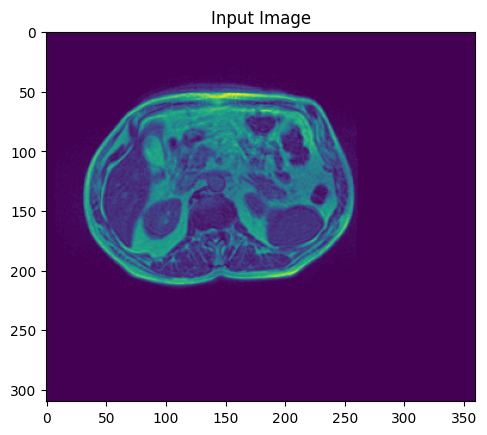

[0. 1.]
[0 1]


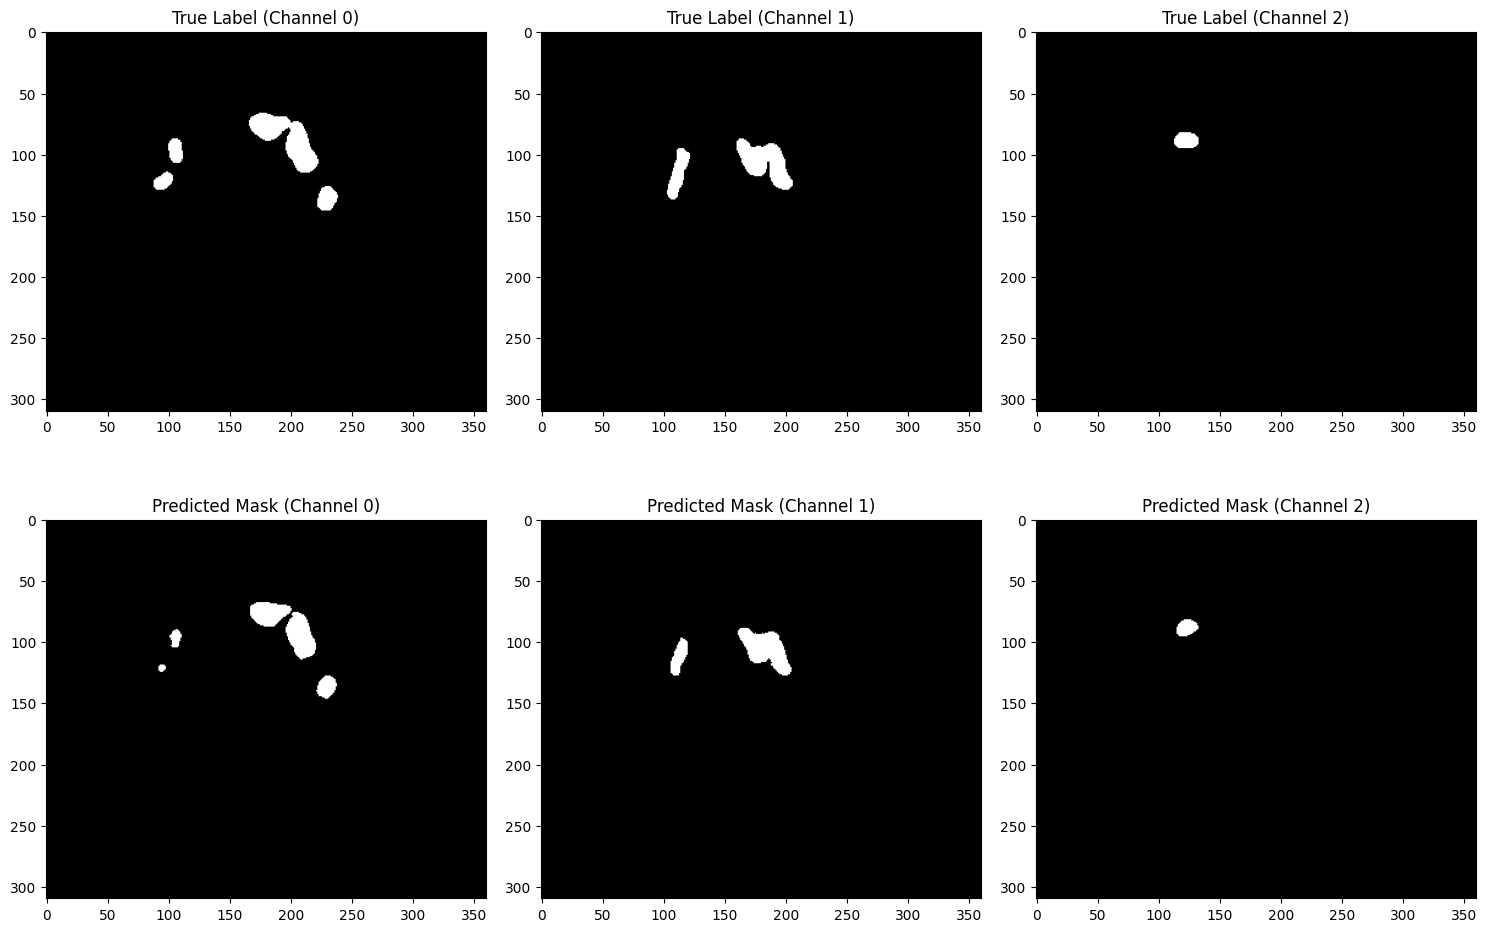

In [ ]:
# Visualize a single test sample
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

model.eval()

test_sample = next(iter(test_loader))
# test_sample = next(iter(test_loader))
inputs, true_labels = test_sample

inputs, true_labels = inputs.to(device), true_labels.to(device)

with torch.no_grad():
    outputs = model(inputs)
    # outputs = model(inputs)['out']

probs = torch.sigmoid(outputs)
predicted_labels = (probs > 0.5).float()


import matplotlib.pyplot as plt

input_image = inputs.cpu().squeeze().numpy()
plt.imshow(input_image[1,:,:])
plt.title("Input Image")
plt.show()

# Move the true_label and pred_mask back to the CPU and remove the batch dimension
true_label = true_labels.squeeze().cpu().numpy()
pred_mask = predicted_labels.squeeze().cpu().numpy()

print(np.unique(pred_mask))
print(np.unique(true_label))
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

for i in range(3):
    ax[0, i].imshow(true_label[i,:,:], cmap='gray')
    ax[0, i].set_title(f"True Label (Channel {i})")
    
    ax[1, i].imshow(pred_mask[i,:,:], cmap='gray')
    ax[1, i].set_title(f"Predicted Mask (Channel {i})")

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/EECS545 Final Project/resnet_vit.png')
plt.show()



<Figure size 640x480 with 0 Axes>

In [ ]:
print(true_label.shape)
print(pred_mask.shape)
np.save('/content/drive/MyDrive/EECS545 Final Project/Result_comparison/pred_mask.npy', pred_mask)
np.save('/content/drive/MyDrive/EECS545 Final Project/Result_comparison/true_label.npy', true_label)

(3, 310, 360)
(3, 310, 360)


## ViT

In [ ]:
import numpy as np
import cv2
import os
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

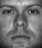

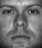

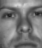

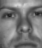

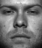

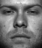

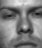

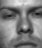

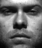

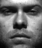

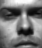

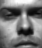

In [ ]:
def load_npy_files(image_npy_path, mask_npy_path):
    images = np.load(image_npy_path)
    masks = np.load(mask_npy_path)
    return images, masks

def data_augmentation(images, masks, batch_size=8):
    data_gen_args = dict(rotation_range=20,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.1,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         fill_mode='nearest')
    
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    image_datagen.fit(images, augment=True, seed=1)
    mask_datagen.fit(masks, augment=True, seed=1)

    image_generator = image_datagen.flow(images, batch_size=batch_size, seed=1)
    mask_generator = mask_datagen.flow(masks, batch_size=batch_size, seed=1)

    return zip(image_generator, mask_generator)

def visualize_augmented_data(images, masks, num_images_to_show=3):
    for i in range(num_images_to_show):
        image, mask = images[i], masks[i]
        image_augmented, mask_augmented = next(data_augmentation(np.array([image]), np.array([mask])))

        cv2_imshow(image)
        cv2_imshow(mask)
        cv2_imshow(image_augmented[0])
        cv2_imshow(mask_augmented[0])

        cv2.waitKey(0)
        cv2.destroyAllWindows()

if __name__ == "__main__":
    image_npy_path = 'face.npy'
    mask_npy_path = 'face.npy'

    images, masks = load_npy_files(image_npy_path, mask_npy_path)

    images = np.expand_dims(images, axis=-1)  
    masks = np.expand_dims(masks, axis=-1)

    visualize_augmented_data(images, masks)